In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import time
from scipy.stats import kurtosis
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the original dataset
original_df = pd.read_csv('Teacher_3033_CDATutterancesWithCodes.csv')
print("Original dataset loaded. Shape:", original_df.shape)

utterances = original_df['utterance'].tolist()

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(utterances)

Original dataset loaded. Shape: (712, 6)


In [3]:
# Apply LDA
n_topics = 20  # You can adjust this
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
X_lda = lda.fit_transform(X)

print(f"Original data shape: {X.shape}")
print(f"LDA-transformed data shape: {X_lda.shape}")

# Use X_lda for further dimensionality reduction
X = X_lda

Original data shape: (712, 696)
LDA-transformed data shape: (712, 20)


In [4]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# PCA: Use explained variance ratio
pca = PCA()
pca.fit(X_scaled)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
pca_optimal_dims = next(i for i, v in enumerate(cumulative_variance_ratio) if v >= 0.9) + 1

In [6]:
# ICA: Use kurtosis
ica = FastICA(n_components=X_scaled.shape[1], random_state=42)
X_ica = ica.fit_transform(X_scaled)
kurtosis_values = kurtosis(X_ica, axis=0)
ica_optimal_dims = np.sum(np.abs(kurtosis_values) > 1)  # Select components with kurtosis > 1 or < -1

C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


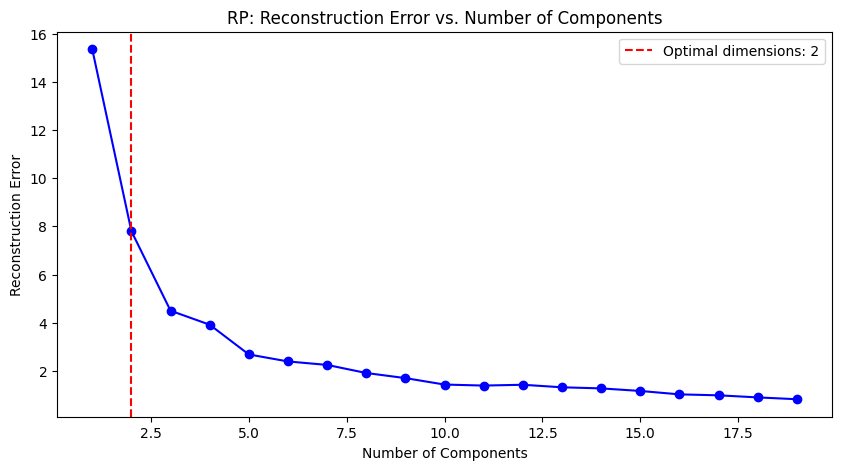

RP optimal dimensions: 2


In [7]:
# RP: Use reconstruction error with elbow method
def rp_reconstruction_error(X, n_components):
    rp = GaussianRandomProjection(n_components=n_components, random_state=42)
    X_rp = rp.fit_transform(X)
    X_reconstructed = np.dot(X_rp, rp.components_)
    return mean_squared_error(X, X_reconstructed)

max_components = min(X_scaled.shape[1], 50)  # Limit to 50 components for efficiency
rp_errors = [rp_reconstruction_error(X_scaled, i) for i in range(1, max_components)]

# Calculate the differences between consecutive errors
error_diffs = np.diff(rp_errors)

# Find the elbow point (where the difference starts to level off)
elbow_point = np.argmin(error_diffs) + 1

rp_optimal_dims = elbow_point + 1  # Add 1 because we started from 1 component

# Plot the reconstruction error
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(rp_errors) + 1), rp_errors, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('RP: Reconstruction Error vs. Number of Components')
plt.axvline(x=rp_optimal_dims, color='r', linestyle='--', label=f'Optimal dimensions: {rp_optimal_dims}')
plt.legend()
plt.show()

print(f"RP optimal dimensions: {rp_optimal_dims}")

In [8]:
# UMAP: Use silhouette score
umap_scores = []
for dims in range(2, 11):  # Limit to 10 dimensions for computational efficiency
    umap_reducer = umap.UMAP(n_components=dims, random_state=42)
    X_umap = umap_reducer.fit_transform(X_scaled)
    kmeans = KMeans(n_clusters=5, random_state=42)
    clusters = kmeans.fit_predict(X_umap)
    umap_scores.append(silhouette_score(X_umap, clusters))

umap_optimal_dims = umap_scores.index(max(umap_scores)) + 2  # +2 because we started from 2 dimensions

print(f"Optimal dimensions - PCA: {pca_optimal_dims}, ICA: {ica_optimal_dims}, RP: {rp_optimal_dims}, UMAP: {umap_optimal_dims}")

C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarnin

Optimal dimensions - PCA: 17, ICA: 20, RP: 2, UMAP: 9


In [9]:
def evaluate_reduction(X_reduced, algorithm_name):
    start_time = time.time()
    
    kmeans = KMeans(n_clusters=5, random_state=42)
    clusters = kmeans.fit_predict(X_reduced)
    sil_score = silhouette_score(X_reduced, clusters)
    
    end_time = time.time()
    time_taken = end_time - start_time
    
    print(f"{algorithm_name} Results:")
    print(f"Reduced data shape: {X_reduced.shape}")
    print(f"Silhouette Score: {sil_score}")
    print(f"Time taken: {time_taken} seconds")
    print("-----------------------------")
    
    return X_reduced, sil_score, time_taken

In [10]:
def evaluate_dimensions(X, max_dims=20):
    results = {algo: {'scores': [], 'times': [], 'best_score': 0, 'best_dims': 0, 'best_data': None} 
               for algo in ['RP', 'PCA', 'ICA', 'UMAP']}
    
    for n_components in range(2, max_dims + 1):
        # RP
        rp = GaussianRandomProjection(n_components=n_components, random_state=42)
        X_rp = rp.fit_transform(X)
        _, sil_rp, time_rp = evaluate_reduction(X_rp, f"RP-{n_components}")
        results['RP']['scores'].append(sil_rp)
        results['RP']['times'].append(time_rp)
        if sil_rp > results['RP']['best_score']:
            results['RP']['best_score'] = sil_rp
            results['RP']['best_dims'] = n_components
            results['RP']['best_data'] = X_rp
        
        # PCA
        pca = PCA(n_components=n_components, random_state=42)
        X_pca = pca.fit_transform(X)
        _, sil_pca, time_pca = evaluate_reduction(X_pca, f"PCA-{n_components}")
        results['PCA']['scores'].append(sil_pca)
        results['PCA']['times'].append(time_pca)
        if sil_pca > results['PCA']['best_score']:
            results['PCA']['best_score'] = sil_pca
            results['PCA']['best_dims'] = n_components
            results['PCA']['best_data'] = X_pca
        
        # ICA
        ica = FastICA(n_components=n_components, random_state=42)
        X_ica = ica.fit_transform(X)
        _, sil_ica, time_ica = evaluate_reduction(X_ica, f"ICA-{n_components}")
        results['ICA']['scores'].append(sil_ica)
        results['ICA']['times'].append(time_ica)
        if sil_ica > results['ICA']['best_score']:
            results['ICA']['best_score'] = sil_ica
            results['ICA']['best_dims'] = n_components
            results['ICA']['best_data'] = X_ica
        
        # UMAP
        umap_reducer = umap.UMAP(n_components=n_components, random_state=42)
        X_umap = umap_reducer.fit_transform(X)
        _, sil_umap, time_umap = evaluate_reduction(X_umap, f"UMAP-{n_components}")
        results['UMAP']['scores'].append(sil_umap)
        results['UMAP']['times'].append(time_umap)
        if sil_umap > results['UMAP']['best_score']:
            results['UMAP']['best_score'] = sil_umap
            results['UMAP']['best_dims'] = n_components
            results['UMAP']['best_data'] = X_umap
    
    return results

In [11]:
# Evaluate dimensions
results = evaluate_dimensions(X_scaled)

RP-2 Results:
Reduced data shape: (712, 2)
Silhouette Score: 0.4073435973132993
Time taken: 0.0260007381439209 seconds
-----------------------------
PCA-2 Results:
Reduced data shape: (712, 2)
Silhouette Score: 0.43985591459889495
Time taken: 0.02099609375 seconds
-----------------------------
ICA-2 Results:
Reduced data shape: (712, 2)
Silhouette Score: 0.4412812724169738
Time taken: 0.023998737335205078 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-2 Results:
Reduced data shape: (712, 2)
Silhouette Score: 0.4151860773563385
Time taken: 0.025003433227539062 seconds
-----------------------------
RP-3 Results:
Reduced data shape: (712, 3)
Silhouette Score: 0.34138987796781695
Time taken: 0.020998716354370117 seconds
-----------------------------
PCA-3 Results:
Reduced data shape: (712, 3)
Silhouette Score: 0.3895898746160002
Time taken: 0.014997005462646484 seconds
-----------------------------
ICA-3 Results:
Reduced data shape: (712, 3)
Silhouette Score: 0.39162364911082315
Time taken: 0.015000581741333008 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-3 Results:
Reduced data shape: (712, 3)
Silhouette Score: 0.3787517845630646
Time taken: 0.021999597549438477 seconds
-----------------------------
RP-4 Results:
Reduced data shape: (712, 4)
Silhouette Score: 0.3306736495458842
Time taken: 0.024999380111694336 seconds
-----------------------------
PCA-4 Results:
Reduced data shape: (712, 4)
Silhouette Score: 0.36733349296827844
Time taken: 0.023996591567993164 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


ICA-4 Results:
Reduced data shape: (712, 4)
Silhouette Score: 0.3627945989433389
Time taken: 0.021996259689331055 seconds
-----------------------------
UMAP-4 Results:
Reduced data shape: (712, 4)
Silhouette Score: 0.40670347213745117
Time taken: 0.03999686241149902 seconds
-----------------------------
RP-5 Results:
Reduced data shape: (712, 5)
Silhouette Score: 0.30213980158492926
Time taken: 0.01499485969543457 seconds
-----------------------------
PCA-5 Results:
Reduced data shape: (712, 5)
Silhouette Score: 0.24953850059357052
Time taken: 0.014996051788330078 seconds
-----------------------------
ICA-5 Results:
Reduced data shape: (712, 5)
Silhouette Score: 0.3095508391850591
Time taken: 0.01799917221069336 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-5 Results:
Reduced data shape: (712, 5)
Silhouette Score: 0.3542715311050415
Time taken: 0.03399801254272461 seconds
-----------------------------
RP-6 Results:
Reduced data shape: (712, 6)
Silhouette Score: 0.184439998189177
Time taken: 0.01800370216369629 seconds
-----------------------------
PCA-6 Results:
Reduced data shape: (712, 6)
Silhouette Score: 0.2746048831424776
Time taken: 0.013997793197631836 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


ICA-6 Results:
Reduced data shape: (712, 6)
Silhouette Score: 0.2592457295680378
Time taken: 0.018996238708496094 seconds
-----------------------------
UMAP-6 Results:
Reduced data shape: (712, 6)
Silhouette Score: 0.37387093901634216
Time taken: 0.03499650955200195 seconds
-----------------------------
RP-7 Results:
Reduced data shape: (712, 7)
Silhouette Score: 0.28004901015514966
Time taken: 0.014999866485595703 seconds
-----------------------------
PCA-7 Results:
Reduced data shape: (712, 7)
Silhouette Score: 0.27394099048957
Time taken: 0.017998218536376953 seconds
-----------------------------
ICA-7 Results:
Reduced data shape: (712, 7)
Silhouette Score: 0.24030983168679546
Time taken: 0.013994932174682617 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-7 Results:
Reduced data shape: (712, 7)
Silhouette Score: 0.36961156129837036
Time taken: 0.032000064849853516 seconds
-----------------------------
RP-8 Results:
Reduced data shape: (712, 8)
Silhouette Score: 0.24526633882868637
Time taken: 0.021998167037963867 seconds
-----------------------------
PCA-8 Results:
Reduced data shape: (712, 8)
Silhouette Score: 0.227998579387302
Time taken: 0.0189969539642334 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


ICA-8 Results:
Reduced data shape: (712, 8)
Silhouette Score: 0.19875214582863376
Time taken: 0.023998498916625977 seconds
-----------------------------
UMAP-8 Results:
Reduced data shape: (712, 8)
Silhouette Score: 0.38882720470428467
Time taken: 0.03299522399902344 seconds
-----------------------------
RP-9 Results:
Reduced data shape: (712, 9)
Silhouette Score: 0.2618578819173562
Time taken: 0.017998695373535156 seconds
-----------------------------
PCA-9 Results:
Reduced data shape: (712, 9)
Silhouette Score: 0.20453539041984806
Time taken: 0.01399850845336914 seconds
-----------------------------
ICA-9 Results:
Reduced data shape: (712, 9)
Silhouette Score: 0.20904336163817194
Time taken: 0.012996435165405273 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-9 Results:
Reduced data shape: (712, 9)
Silhouette Score: 0.4930537939071655
Time taken: 0.03399991989135742 seconds
-----------------------------
RP-10 Results:
Reduced data shape: (712, 10)
Silhouette Score: 0.20330047415249525
Time taken: 0.0260012149810791 seconds
-----------------------------
PCA-10 Results:
Reduced data shape: (712, 10)
Silhouette Score: 0.18866721199090622
Time taken: 0.019994497299194336 seconds
-----------------------------
ICA-10 Results:
Reduced data shape: (712, 10)
Silhouette Score: 0.1832926965228668
Time taken: 0.018000125885009766 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-10 Results:
Reduced data shape: (712, 10)
Silhouette Score: 0.328375905752182
Time taken: 0.03199934959411621 seconds
-----------------------------
RP-11 Results:
Reduced data shape: (712, 11)
Silhouette Score: 0.16224787885812852
Time taken: 0.01600050926208496 seconds
-----------------------------
PCA-11 Results:
Reduced data shape: (712, 11)
Silhouette Score: 0.18098952161012608
Time taken: 0.018999099731445312 seconds
-----------------------------
ICA-11 Results:
Reduced data shape: (712, 11)
Silhouette Score: 0.18611218297765875
Time taken: 0.014998912811279297 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-11 Results:
Reduced data shape: (712, 11)
Silhouette Score: 0.3988293409347534
Time taken: 0.03299570083618164 seconds
-----------------------------
RP-12 Results:
Reduced data shape: (712, 12)
Silhouette Score: 0.20516007244623297
Time taken: 0.024001121520996094 seconds
-----------------------------
PCA-12 Results:
Reduced data shape: (712, 12)
Silhouette Score: 0.17629707590036792
Time taken: 0.015001058578491211 seconds
-----------------------------
ICA-12 Results:
Reduced data shape: (712, 12)
Silhouette Score: 0.16524040383704167
Time taken: 0.01800060272216797 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-12 Results:
Reduced data shape: (712, 12)
Silhouette Score: 0.4095388650894165
Time taken: 0.03099966049194336 seconds
-----------------------------
RP-13 Results:
Reduced data shape: (712, 13)
Silhouette Score: 0.1811525507491898
Time taken: 0.02299952507019043 seconds
-----------------------------
PCA-13 Results:
Reduced data shape: (712, 13)
Silhouette Score: 0.15145282627609677
Time taken: 0.01599860191345215 seconds
-----------------------------
ICA-13 Results:
Reduced data shape: (712, 13)
Silhouette Score: 0.15394256122937047
Time taken: 0.016778230667114258 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-13 Results:
Reduced data shape: (712, 13)
Silhouette Score: 0.42714619636535645
Time taken: 0.020998239517211914 seconds
-----------------------------
RP-14 Results:
Reduced data shape: (712, 14)
Silhouette Score: 0.1754251791231037
Time taken: 0.020374059677124023 seconds
-----------------------------
PCA-14 Results:
Reduced data shape: (712, 14)
Silhouette Score: 0.15551708124952535
Time taken: 0.013996601104736328 seconds
-----------------------------
ICA-14 Results:
Reduced data shape: (712, 14)
Silhouette Score: 0.1604030273486686
Time taken: 0.0200040340423584 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-14 Results:
Reduced data shape: (712, 14)
Silhouette Score: 0.35918930172920227
Time taken: 0.0469973087310791 seconds
-----------------------------
RP-15 Results:
Reduced data shape: (712, 15)
Silhouette Score: 0.2089804285883558
Time taken: 0.02699875831604004 seconds
-----------------------------
PCA-15 Results:
Reduced data shape: (712, 15)
Silhouette Score: 0.15278119596870837
Time taken: 0.023000478744506836 seconds
-----------------------------
ICA-15 Results:
Reduced data shape: (712, 15)
Silhouette Score: 0.1516639307053742
Time taken: 0.02000141143798828 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-15 Results:
Reduced data shape: (712, 15)
Silhouette Score: 0.3717564344406128
Time taken: 0.03548097610473633 seconds
-----------------------------
RP-16 Results:
Reduced data shape: (712, 16)
Silhouette Score: 0.252446912095181
Time taken: 0.01599860191345215 seconds
-----------------------------
PCA-16 Results:
Reduced data shape: (712, 16)
Silhouette Score: 0.1154603791431022
Time taken: 0.017000198364257812 seconds
-----------------------------
ICA-16 Results:
Reduced data shape: (712, 16)
Silhouette Score: 0.12003171198062737
Time taken: 0.015999555587768555 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-16 Results:
Reduced data shape: (712, 16)
Silhouette Score: 0.3781193792819977
Time taken: 0.03526020050048828 seconds
-----------------------------
RP-17 Results:
Reduced data shape: (712, 17)
Silhouette Score: 0.1921343477292754
Time taken: 0.016996383666992188 seconds
-----------------------------
PCA-17 Results:
Reduced data shape: (712, 17)
Silhouette Score: 0.15435860133580573
Time taken: 0.018999099731445312 seconds
-----------------------------
ICA-17 Results:
Reduced data shape: (712, 17)
Silhouette Score: 0.1167261792788108
Time taken: 0.014000415802001953 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-17 Results:
Reduced data shape: (712, 17)
Silhouette Score: 0.3085855543613434
Time taken: 0.03800559043884277 seconds
-----------------------------
RP-18 Results:
Reduced data shape: (712, 18)
Silhouette Score: 0.1874786298456101
Time taken: 0.018993139266967773 seconds
-----------------------------
PCA-18 Results:
Reduced data shape: (712, 18)
Silhouette Score: 0.12305872146544834
Time taken: 0.013998746871948242 seconds
-----------------------------
ICA-18 Results:
Reduced data shape: (712, 18)
Silhouette Score: 0.11965870769367881
Time taken: 0.01300501823425293 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-18 Results:
Reduced data shape: (712, 18)
Silhouette Score: 0.3417453467845917
Time taken: 0.023005962371826172 seconds
-----------------------------
RP-19 Results:
Reduced data shape: (712, 19)
Silhouette Score: 0.15665974028984855
Time taken: 0.01699352264404297 seconds
-----------------------------
PCA-19 Results:
Reduced data shape: (712, 19)
Silhouette Score: 0.1280422651843168
Time taken: 0.013993501663208008 seconds
-----------------------------
ICA-19 Results:
Reduced data shape: (712, 19)
Silhouette Score: 0.14965478857695713
Time taken: 0.013997316360473633 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-19 Results:
Reduced data shape: (712, 19)
Silhouette Score: 0.3348850607872009
Time taken: 0.03499650955200195 seconds
-----------------------------
RP-20 Results:
Reduced data shape: (712, 20)
Silhouette Score: 0.17903500841810935
Time taken: 0.021997690200805664 seconds
-----------------------------
PCA-20 Results:
Reduced data shape: (712, 20)
Silhouette Score: 0.1280422651843168
Time taken: 0.01798844337463379 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


ICA-20 Results:
Reduced data shape: (712, 20)
Silhouette Score: 0.12468282388902635
Time taken: 0.028078317642211914 seconds
-----------------------------
UMAP-20 Results:
Reduced data shape: (712, 20)
Silhouette Score: 0.32010114192962646
Time taken: 0.03495049476623535 seconds
-----------------------------


In [12]:
# Apply dimensionality reduction with optimal dimensions
pca = PCA(n_components=pca_optimal_dims)
X_pca = pca.fit_transform(X_scaled)

ica = FastICA(n_components=ica_optimal_dims, random_state=42)
X_ica = ica.fit_transform(X_scaled)

rp = GaussianRandomProjection(n_components=rp_optimal_dims, random_state=42)
X_rp = rp.fit_transform(X_scaled)

umap_reducer = umap.UMAP(n_components=umap_optimal_dims, random_state=42)
X_umap = umap_reducer.fit_transform(X_scaled)

C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [13]:
# Add reduced dimensions to the original dataset
df_with_dimensions = original_df.copy()

for i in range(pca_optimal_dims):
    df_with_dimensions[f'PCA_dim_{i+1}'] = X_pca[:, i]

for i in range(ica_optimal_dims):
    df_with_dimensions[f'ICA_dim_{i+1}'] = X_ica[:, i]

for i in range(rp_optimal_dims):
    df_with_dimensions[f'RP_dim_{i+1}'] = X_rp[:, i]

for i in range(umap_optimal_dims):
    df_with_dimensions[f'UMAP_dim_{i+1}'] = X_umap[:, i]

In [14]:
# Function to add dimensions and save CSV
def add_dimensions_and_save(original_df, X_reduced, algorithm_name, optimal_dims):
    df_with_best_dimensions = original_df.copy()
    for i in range(optimal_dims):
        df_with_dimensions[f'{algorithm_name}_dim_{i+1}'] = X_reduced[:, i]
    
    # Save the new dataset with added dimensions
    filename = f'dataset3033_with_{algorithm_name}_optimal_dimensions.csv'
    df_with_dimensions.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"Dataset with {algorithm_name} dimensions has been saved as '{filename}'")
    
    return df_with_dimensions

# PCA
df_pca = add_dimensions_and_save(original_df, X_pca, 'PCA', pca_optimal_dims)

# ICA
df_ica = add_dimensions_and_save(original_df, X_ica, 'ICA', ica_optimal_dims)

# RP
df_rp = add_dimensions_and_save(original_df, X_rp, 'RP', rp_optimal_dims)

# UMAP
df_umap = add_dimensions_and_save(original_df, X_umap, 'UMAP', umap_optimal_dims)

# Display the first few rows and basic info of one of the new datasets (e.g., PCA)
print("\nFirst few rows of the dataset with PCA dimensions:")
print(df_pca.head())
print("\nBasic info of the dataset with PCA dimensions:")
print(df_pca.info())

Dataset with PCA dimensions has been saved as 'dataset3033_with_PCA_optimal_dimensions.csv'
Dataset with ICA dimensions has been saved as 'dataset3033_with_ICA_optimal_dimensions.csv'
Dataset with RP dimensions has been saved as 'dataset3033_with_RP_optimal_dimensions.csv'
Dataset with UMAP dimensions has been saved as 'dataset3033_with_UMAP_optimal_dimensions.csv'

First few rows of the dataset with PCA dimensions:
   number  TeacherID speaker  \
0       1       3033       T   
1       2       3033       T   
2       3       3033       T   
3       4       3033       S   
4       5       3033       T   

                                           utterance  ut   rc  PCA_dim_1  \
0  Alright, let us do science. Who wants to do ca...   P  NaN  -0.559111   
1  Guys, as we go through the review, pay attenti...   P  NaN  -0.423169   
2  Alright? Stephanie your question is Number 8, ...   Q   SK  -0.158530   
3                       Electricity? I do not know.   Rs   SK   0.083925   
4  Okay

In [15]:
# create a single dataset with all dimensions from all algorithms:
df_all = original_df.copy()
for algo, X_reduced, optimal_dims in [('PCA', X_pca, pca_optimal_dims), 
                                      ('ICA', X_ica, ica_optimal_dims), 
                                      ('RP', X_rp, rp_optimal_dims), 
                                      ('UMAP', X_umap, umap_optimal_dims)]:
    for i in range(optimal_dims):
        df_all[f'{algo}_dim_{i+1}'] = X_reduced[:, i]

df_all.to_csv('dataset3033_with_all_dimensions.csv', index=False, encoding='utf-8-sig')
print("\nDataset with all dimensions has been saved as 'dataset_with_all_dimensions.csv'")


Dataset with all dimensions has been saved as 'dataset_with_all_dimensions.csv'


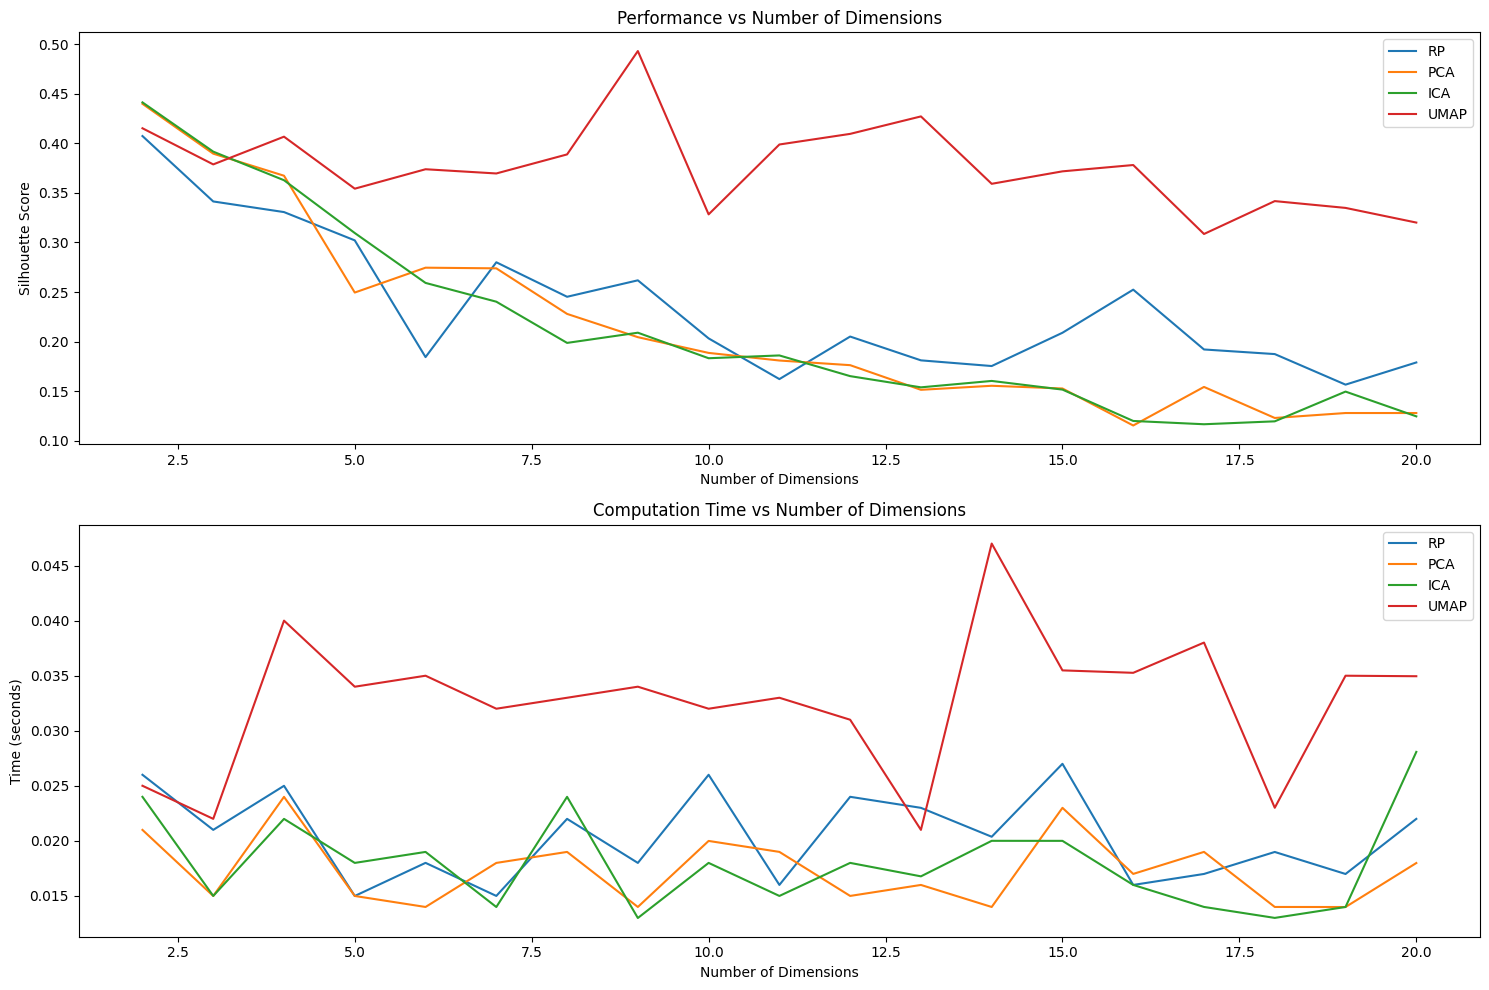

In [16]:
# Plot results
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
for algo, data in results.items():
    plt.plot(range(2, len(data['scores']) + 2), data['scores'], label=algo)
plt.xlabel('Number of Dimensions')
plt.ylabel('Silhouette Score')
plt.legend()
plt.title('Performance vs Number of Dimensions')

plt.subplot(2, 1, 2)
for algo, data in results.items():
    plt.plot(range(2, len(data['times']) + 2), data['times'], label=algo)
plt.xlabel('Number of Dimensions')
plt.ylabel('Time (seconds)')
plt.legend()
plt.title('Computation Time vs Number of Dimensions')

plt.tight_layout()
plt.show()

In [17]:
# Save the best performing datasets
for algo, data in results.items():
    best_dims = data['best_dims']
    best_score = data['best_score']
    best_data = data['best_data']
    
    print(f"{algo}: Best dimensions = {best_dims}, Best score = {best_score}")
    
    # Save as CSV
    df = pd.DataFrame(best_data, columns=[f"Dim_{i+1}" for i in range(best_dims)])
    df.to_csv(f"3033_{algo}_best_{best_dims}d.csv", index=False)
    print(f"Saved 3033_{algo} data with {best_dims} dimensions to {algo}_best_{best_dims}d.csv")

print("All best-performing datasets have been saved.")

RP: Best dimensions = 2, Best score = 0.4073435973132993
Saved 3033_RP data with 2 dimensions to RP_best_2d.csv
PCA: Best dimensions = 2, Best score = 0.43985591459889495
Saved 3033_PCA data with 2 dimensions to PCA_best_2d.csv
ICA: Best dimensions = 2, Best score = 0.4412812724169738
Saved 3033_ICA data with 2 dimensions to ICA_best_2d.csv
UMAP: Best dimensions = 9, Best score = 0.4930537939071655
Saved 3033_UMAP data with 9 dimensions to UMAP_best_9d.csv
All best-performing datasets have been saved.


In [18]:
# Extract the best dimensions based on the highest silhouette score for each algorithm
best_dimensions = {
    'PCA': results['PCA']['best_dims'],
    'ICA': results['ICA']['best_dims'],
    'RP': results['RP']['best_dims'],
    'UMAP': results['UMAP']['best_dims']
}

print(f"Best dimensions based on silhouette score - PCA: {best_dimensions['PCA']}, ICA: {best_dimensions['ICA']}, RP: {best_dimensions['RP']}, UMAP: {best_dimensions['UMAP']}")

Best dimensions based on silhouette score - PCA: 2, ICA: 2, RP: 2, UMAP: 9


In [19]:
# Function to add best dimensions to the original dataset and save CSV
def add_best_dimensions_and_save(original_df, X_reduced, algorithm_name, optimal_dims):
    df_with_best_dimensions = original_df.copy()
    
    # Add only the best dimensions
    for i in range(optimal_dims):
        df_with_best_dimensions[f'{algorithm_name}_best_dim_{i+1}'] = X_reduced[:, i]
    
    # Save the new dataset with added best dimensions
    filename = f'dataset3033_with_{algorithm_name}_best_dimensions.csv'
    df_with_best_dimensions.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"Dataset with {algorithm_name} best dimensions has been saved as '{filename}'")
    
    return df_with_best_dimensions

In [20]:
# Apply dimensionality reduction and save results
df_pca = add_best_dimensions_and_save(original_df, X_pca, 'PCA', pca_optimal_dims)
df_ica = add_best_dimensions_and_save(original_df, X_ica, 'ICA', ica_optimal_dims)
df_rp = add_best_dimensions_and_save(original_df, X_rp, 'RP', rp_optimal_dims)
df_umap = add_best_dimensions_and_save(original_df, X_umap, 'UMAP', umap_optimal_dims)

# Display the first few rows and basic info of one of the new datasets (e.g., PCA)
print("\nFirst few rows of the dataset with PCA best dimensions:")
print(df_pca.head())
print("\nBasic info of the dataset with PCA best dimensions:")
print(df_pca.info())

Dataset with PCA best dimensions has been saved as 'dataset3033_with_PCA_best_dimensions.csv'
Dataset with ICA best dimensions has been saved as 'dataset3033_with_ICA_best_dimensions.csv'
Dataset with RP best dimensions has been saved as 'dataset3033_with_RP_best_dimensions.csv'
Dataset with UMAP best dimensions has been saved as 'dataset3033_with_UMAP_best_dimensions.csv'

First few rows of the dataset with PCA best dimensions:
   number  TeacherID speaker  \
0       1       3033       T   
1       2       3033       T   
2       3       3033       T   
3       4       3033       S   
4       5       3033       T   

                                           utterance  ut   rc  PCA_best_dim_1  \
0  Alright, let us do science. Who wants to do ca...   P  NaN       -0.559111   
1  Guys, as we go through the review, pay attenti...   P  NaN       -0.423169   
2  Alright? Stephanie your question is Number 8, ...   Q   SK       -0.158530   
3                       Electricity? I do not know

In [21]:
# Create a single dataset with best dimensions from all algorithms
df_all_best = original_df.copy()
for algo, X_reduced, optimal_dims in [('PCA', X_pca, pca_optimal_dims), 
                                      ('ICA', X_ica, ica_optimal_dims), 
                                      ('RP', X_rp, rp_optimal_dims), 
                                      ('UMAP', X_umap, umap_optimal_dims)]:
    for i in range(optimal_dims):
        df_all_best[f'{algo}_best_dim_{i+1}'] = X_reduced[:, i]

df_all_best.to_csv('dataset3033_with_all_best_dimensions.csv', index=False, encoding='utf-8-sig')
print("\nDataset with all best dimensions has been saved as 'dataset3033_with_all_best_dimensions.csv'")

# Print the number of best dimensions for each algorithm
print(f"\nNumber of best dimensions:")
print(f"PCA: {pca_optimal_dims}")
print(f"ICA: {ica_optimal_dims}")
print(f"RP: {rp_optimal_dims}")
print(f"UMAP: {umap_optimal_dims}")


Dataset with all best dimensions has been saved as 'dataset3033_with_all_best_dimensions.csv'

Number of best dimensions:
PCA: 17
ICA: 20
RP: 2
UMAP: 9


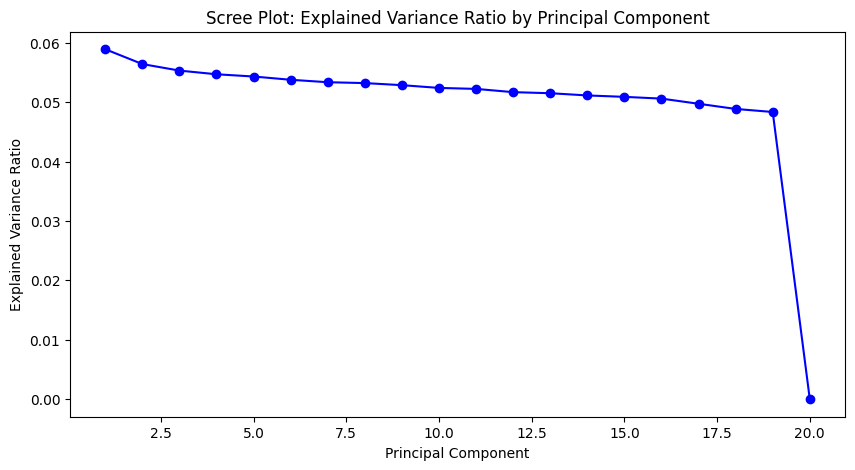

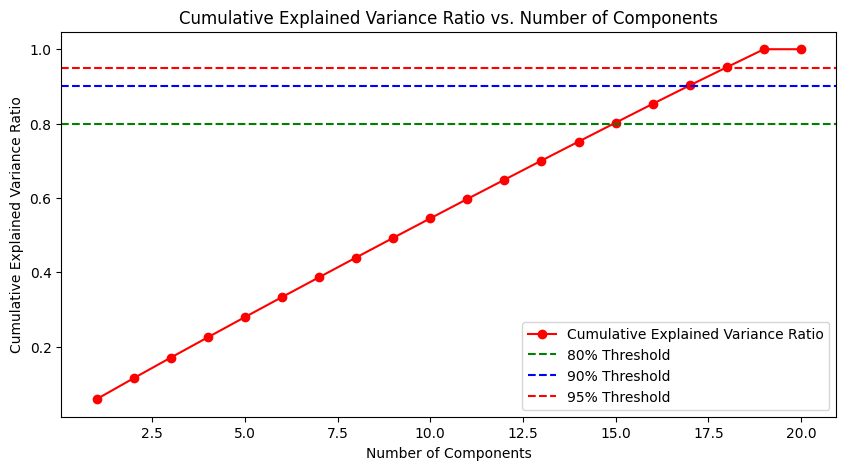

Number of components needed for 80.0% accuracy: 15
Number of components needed for 90.0% accuracy: 17
Number of components needed for 95.0% accuracy: 18


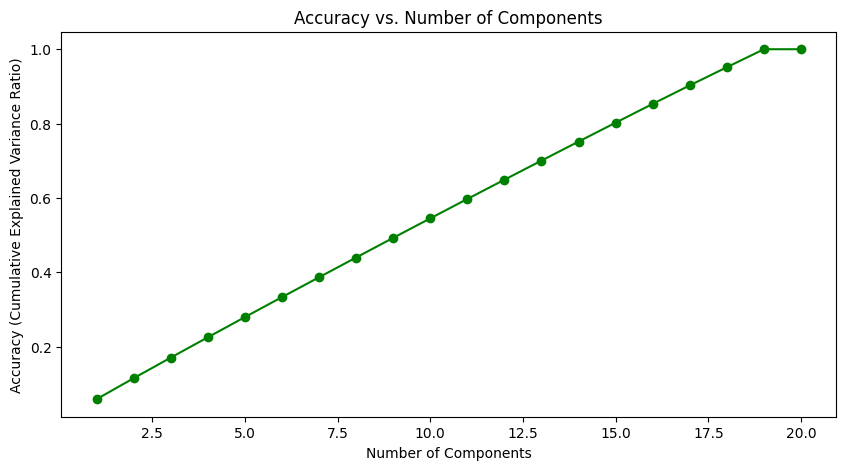

In [22]:
# PCA: Accuracy graphs with eigenvalues
pca = PCA()
pca.fit(X_scaled)

# Scree plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot: Explained Variance Ratio by Principal Component')
plt.show()

# Cumulative explained variance ratio plot
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'ro-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.axhline(y=0.8, color='g', linestyle='--')
plt.axhline(y=0.9, color='b', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.legend(['Cumulative Explained Variance Ratio', '80% Threshold', '90% Threshold', '95% Threshold'])
plt.show()

# Print the number of components needed for different accuracy levels
accuracy_levels = [0.8, 0.9, 0.95]
for level in accuracy_levels:
    n_components = next(i for i, v in enumerate(cumulative_variance_ratio) if v >= level) + 1
    print(f"Number of components needed for {level*100}% accuracy: {n_components}")

# Accuracy vs. Number of Components
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'go-')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy (Cumulative Explained Variance Ratio)')
plt.title('Accuracy vs. Number of Components')
plt.show()

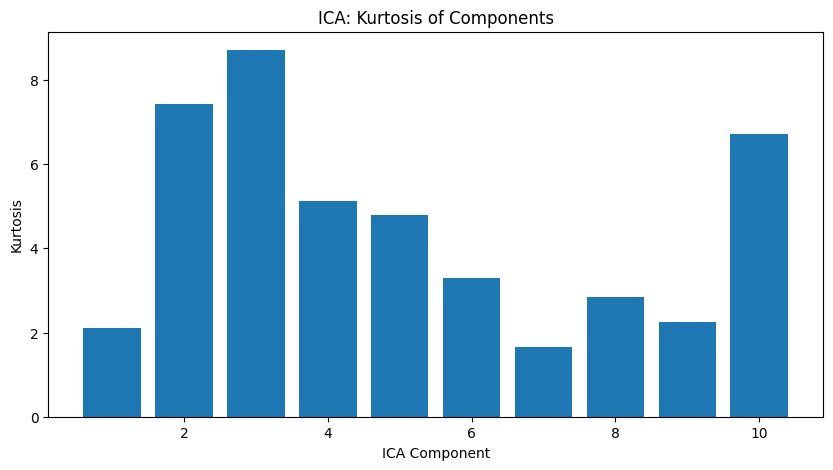

Kurtosis values of ICA components:
[2.11433897 7.43183337 8.70911256 5.12516077 4.79087867 3.28954632
 1.65399257 2.83692659 2.24441338 6.7051328 ]


In [23]:
# 2. ICA: Kurtosis of components
ica = FastICA(n_components=10, random_state=42)
X_ica = ica.fit_transform(X_scaled)

kurtosis_values = kurtosis(X_ica, axis=0)
plt.figure(figsize=(10, 5))
plt.bar(range(1, 11), kurtosis_values)
plt.xlabel('ICA Component')
plt.ylabel('Kurtosis')
plt.title('ICA: Kurtosis of Components')
plt.show()

print("Kurtosis values of ICA components:")
print(kurtosis_values)

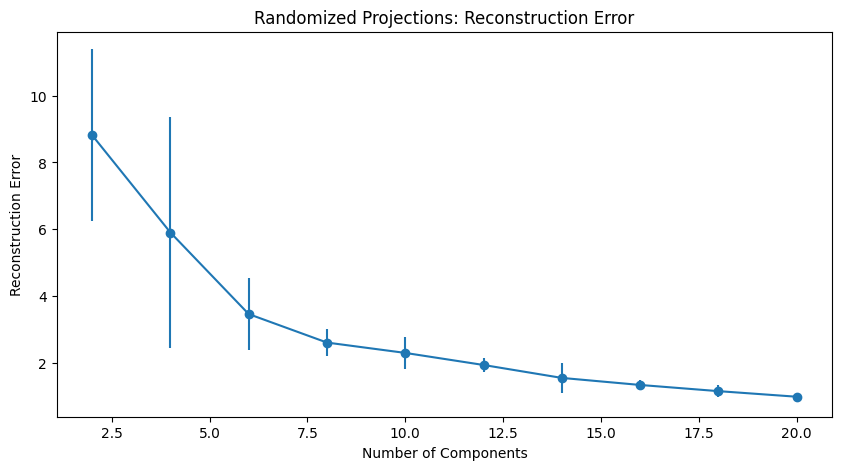

In [24]:
# 3. Randomized Projections: Reconstruction error and variation
def rp_reconstruction_error(X, n_components, n_runs=5):
    errors = []
    for _ in range(n_runs):
        rp = GaussianRandomProjection(n_components=n_components, random_state=None)
        X_rp = rp.fit_transform(X)
        X_reconstructed = np.dot(X_rp, rp.components_)
        error = mean_squared_error(X, X_reconstructed)
        errors.append(error)
    return np.mean(errors), np.std(errors)

n_components_range = range(2, 21, 2)
mean_errors = []
std_errors = []

for n_components in n_components_range:
    mean_error, std_error = rp_reconstruction_error(X_scaled, n_components)
    mean_errors.append(mean_error)
    std_errors.append(std_error)

plt.figure(figsize=(10, 5))
plt.errorbar(n_components_range, mean_errors, yerr=std_errors, fmt='o-')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Randomized Projections: Reconstruction Error')
plt.show()

In [25]:
# 4. Rank and Colinearity
rank = np.linalg.matrix_rank(X_scaled)
print(f"Rank of the data: {rank}")

Rank of the data: 19


In [26]:
# Compute correlation matrix
corr_matrix = np.corrcoef(X_scaled.T)

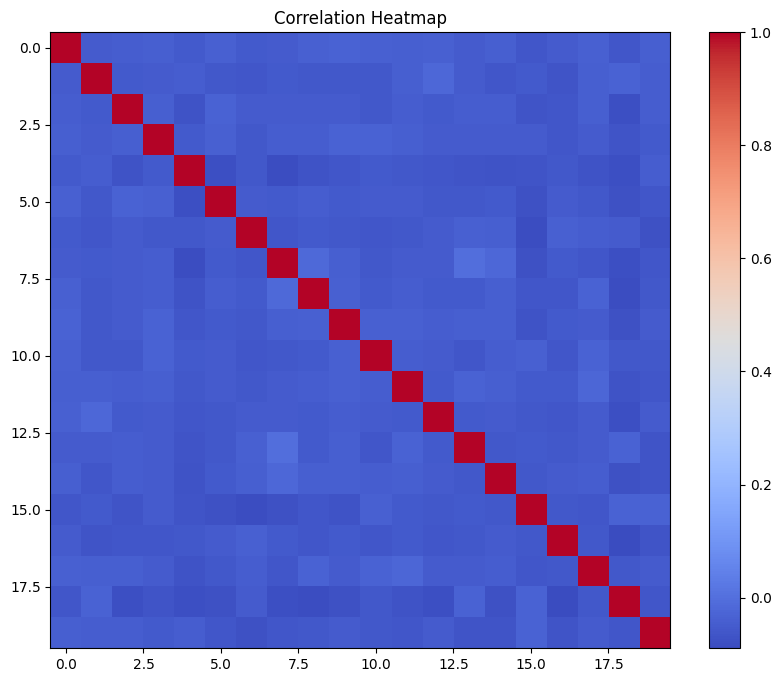

In [27]:
# Plot correlation heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Correlation Heatmap')
plt.show()

In [28]:
# Compute and print condition number
cond_num = np.linalg.cond(X_scaled)
print(f"Condition number: {cond_num}")

Condition number: 395887925834341.5


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


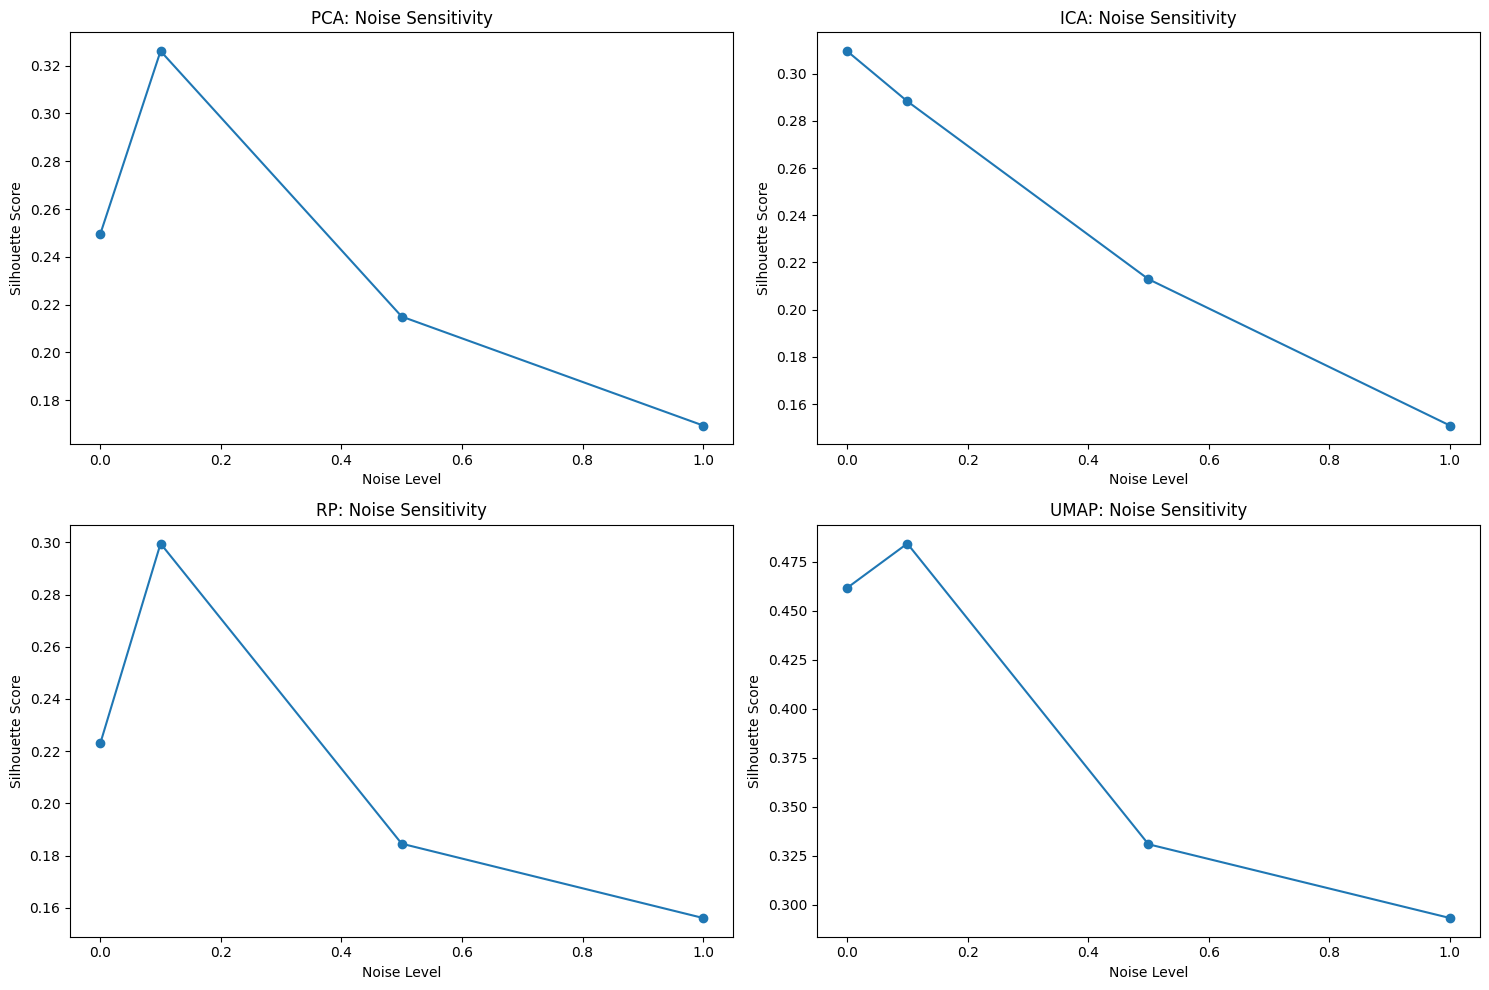

In [29]:
# 5. Noise sensitivity
def add_noise(X, noise_level):
    return X + np.random.normal(0, noise_level, X.shape)

noise_levels = [0, 0.1, 0.5, 1.0]
algorithms = [PCA(n_components=5), FastICA(n_components=5), GaussianRandomProjection(n_components=5), umap.UMAP(n_components=5)]
algo_names = ['PCA', 'ICA', 'RP', 'UMAP']

plt.figure(figsize=(15, 10))

for i, algo in enumerate(algorithms):
    sil_scores = []
    for noise in noise_levels:
        X_noisy = add_noise(X_scaled, noise)
        X_reduced = algo.fit_transform(X_noisy)
        kmeans = KMeans(n_clusters=5, random_state=42)
        clusters = kmeans.fit_predict(X_reduced)
        sil_score = silhouette_score(X_reduced, clusters)
        sil_scores.append(sil_score)
    
    plt.subplot(2, 2, i+1)
    plt.plot(noise_levels, sil_scores, 'o-')
    plt.xlabel('Noise Level')
    plt.ylabel('Silhouette Score')
    plt.title(f'{algo_names[i]}: Noise Sensitivity')

plt.tight_layout()
plt.show()